### description of the problem

there are sources in the FermiLAT catalog described as 'PLSuperExpCutoff' which are not properly described by gammapy. Lets try to understand it

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
import yaml

from gammapy.catalog import CATALOG_REGISTRY
from gammapy.data import EventList
from gammapy.datasets import MapDataset
from gammapy.irf import PSFMap, EDispKernelMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    TemplateSpectralModel,
    PowerLawNormSpectralModel,
    Models,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    create_fermi_isotropic_diffuse_model,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.modeling import Fit

### Opening one dataset for getting geom

In [2]:
dataset_idx = 1
n_bin_met = 0

dataset_names = ['low_energy', 'med_energy', 'hi_energy']
main_path = '/home/woody/caph/mppi062h/woody_output/final/fermilat/'

folder = f'{main_path}/{dataset_names[dataset_idx]}/{n_bin_met}_bin_met'
dataset = MapDataset.read(f'{folder}/fermi_dataset.fits')

### getting the sources from 4FGL for this geom

In [3]:
geom = dataset.counts.geom
fgl = CATALOG_REGISTRY.get_cls("4fgl")()
inside_geom = (geom.drop('energy')).contains(fgl.positions)
idx = np.where(inside_geom)[0]

sky_models = []
cat_models = []
for i in idx:        
    mo = fgl[i].sky_model()    
    if type(mo.spectral_model) == SuperExpCutoffPowerLaw4FGLSpectralModel:
        sky_models.append(mo)
        cat_models.append(fgl[i])

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["

### now testing how this spectrum really looks like

In [4]:
k_function = lambda E, amp, ref, expf, i1, i2 : (amp*(E/ref)**-i1)*np.e**(expf*(ref**i2-E**i2))

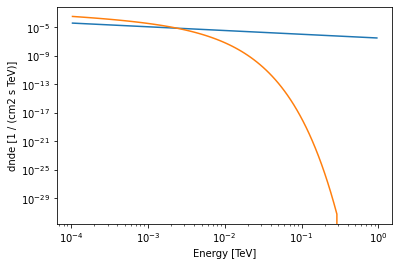

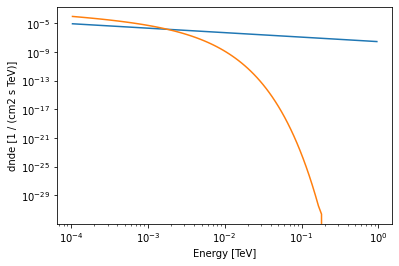

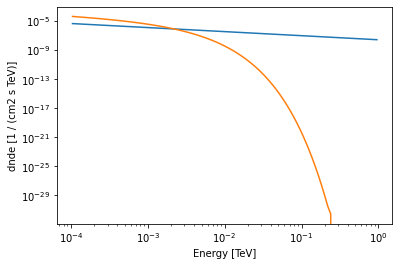

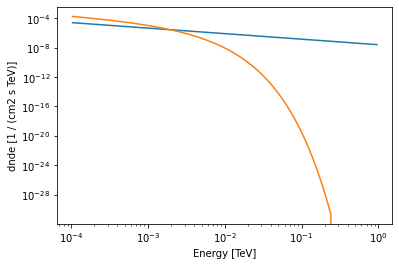

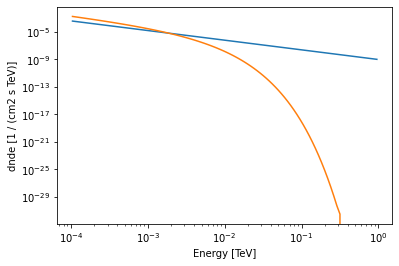

In [5]:
x_axis=np.logspace(2, 6, 100)

for cat, sky in zip(cat_models, sky_models):
    sky.spectral_model.plot(energy_bounds=[100*u.MeV, 1*u.TeV])
    par = sky.parameters
    y = k_function(x_axis, par['amplitude'].value, par['reference'].value, par['expfactor'].value, par['index_1'].value, par['index_2'].value)
    new_spec = TemplateSpectralModel(x_axis*u.MeV, y/(u.cm**2*u.s*u.MeV))
    new_spec.plot(energy_bounds=[100*u.MeV, 1*u.TeV])
    plt.show()